# Numerical Solvers

In [8]:
import os
import numpy as np 
from scipy.optimize import curve_fit
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.integrate import quad
import matplotlib.pyplot as plt

## 1. Moisture Gain -- without experimental data

In [2]:
# GAB model parameters
# based on a packaged cassava-flour-based baked product(from literature: doi:10.1016/j.jfoodeng.2010.04.031)
W_m = 2.5 # monolayer moisture content(g water / g dry solids)
C = 49.1
K = 1.1 

# packaging parameters
P_w = 1e-12 # water vapour permeability of the package
A = 0.015 # surface area
L = 1e-4 # thickness
p_0 = 3170  # saturation vapour pressure of water (T = 25°C)
W_s = 0.05 # mass of dry solids of the food
aw_env = 0.6 # environmental water activity
aw_c = 0.55 # critical water activity of the food

In [3]:
def w(aw):
    return W_m * C * K * aw / ((1 - K * aw) * (1 - K * aw + C * K * aw))

def S(aw):
    delta = 1e-5
    return (w(aw+delta) - w(aw-delta)) / (2 * delta)

def daw_dt(t, aw):
    if S(aw[0])<= 0:
        return [0.0]
    return [(P_w * A * p_0 * (aw_env - aw[0])) / (W_s * L * S(aw[0]))]


In [4]:
aw_0 = 0.3
t_span = (0, 1e7)
solver = solve_ivp(daw_dt, t_span, [aw_0], method='RK45', dense_output=True, max_step=100)

t_c = None
for t,aw in zip(solver.t, solver.y[0]):
    if aw >= aw_c:
        t_c = t/(60*60*24)
        break

if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 26.83352097 days


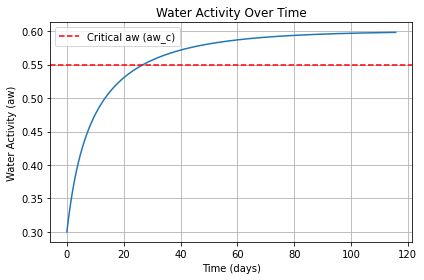

In [5]:
plt.plot(solver.t/(60*60*24), solver.y[0])
plt.xlabel('Time (days)')
plt.ylabel('Water Activity (aw)')
plt.title('Water Activity Over Time')
plt.axhline(y=aw_c, color='r', linestyle='--', label='Critical aw (aw_c)')
plt.legend()
plt.grid()
plt.show()

## * 1. Moisture Gain - with experimental data

### 1.1 Reading data and visualisation

In [ ]:
import os

print(ROOT_DIR)

/run/user/1132325/gvfs/sftp:host=login.hpc.ic.ac.uk,user=jea4117/rds/general/user/jea4117/home/IRP_repositories/2025/irp-jc2024/src


In [17]:
ROOT_DIR = os.path.abspath(os.curdir)
data = pd.ExcelFile(f'{ROOT_DIR}/data/gab_test_data.xlsx')
saltin_df = data.parse('Saltin_25')
snack_qa_df = data.parse('Snack_Q_A_25')

In [18]:
print(saltin_df)

        aw  moisture
0   0.0891    0.0234
1   0.0895    0.0231
2   0.0912    0.0237
3   0.0960    0.0227
4   0.0976    0.0246
5   0.1081    0.0259
6   0.1316    0.0282
7   0.1776    0.0326
8   0.2446    0.0406
9   0.3228    0.0516
10  0.4157    0.0648
11  0.4958    0.0787
12  0.5692    0.0929
13  0.6388    0.1073
14  0.6960    0.1221
15  0.7476    0.1393
16  0.7920    0.1604
17  0.8245    0.1821
18  0.8472    0.2009
19  0.8622    0.2173
20  0.8744    0.2319
21  0.8834    0.2449
22  0.8975    0.2670
23  0.9022    0.2769
24  0.9082    0.2858
25  0.9111    0.2947
26  0.9153    0.3030
27  0.9193    0.3106
28  0.9231    0.3181
29  0.9255    0.3252
30  0.9279    0.3316
31  0.9303    0.3381
32  0.9310    0.3435
33  0.9335    0.3487
34  0.9348    0.3535
35  0.9360    0.3586


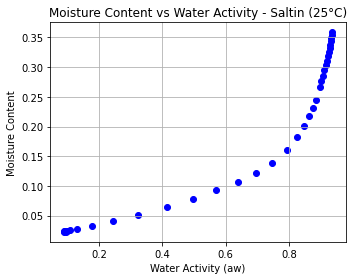

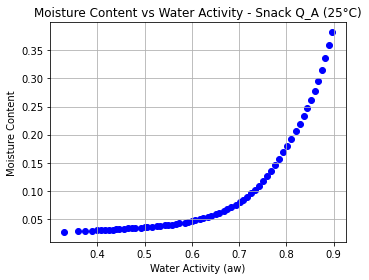

In [19]:
def plot_scatter(df, name):
    aw = df['aw']
    moisture = df['moisture']

    plt.figure(figsize=(5,4))
    plt.scatter(aw, moisture, color='blue')
    plt.xlabel('Water Activity (aw)')
    plt.ylabel('Moisture Content')
    plt.title(f'Moisture Content vs Water Activity - {name} (25°C)')
    plt.grid()
    plt.show()

plot_scatter(saltin_df, 'Saltin')
plot_scatter(snack_qa_df, 'Snack Q_A')

### 1.2 Finding GAB parameters using curve fitting

In [20]:
def gab_model(aw, W_m, C, K):
    return W_m * C * K * aw / ((1 - K * aw) * (1 - K * aw + C * K * aw))

def fit_gab_model(aw, w, init_params=None):
    if init_params is not None:
        params, _ = curve_fit(gab_model, aw, w, p0=init_params, maxfev=10000)
        return params

In [21]:
# GAB model parameters - initial guess
W_m = 0.05
C = 10.0
K = 0.8
init_params = [W_m, C, K]

In [22]:
params_saltin = fit_gab_model(saltin_df['aw'], saltin_df['moisture'], init_params=init_params)
params_snack_qa = fit_gab_model(snack_qa_df['aw'], snack_qa_df['moisture'], init_params=init_params)

print("Fitted parameters for Saltin:", params_saltin)
print("Fitted parameters for Snack_Q_A:", params_snack_qa)

Fitted parameters for Saltin: [ 0.04212285 11.66984779  0.94269247]
Fitted parameters for Snack_Q_A: [2.79351094 0.0074031  0.8878376 ]


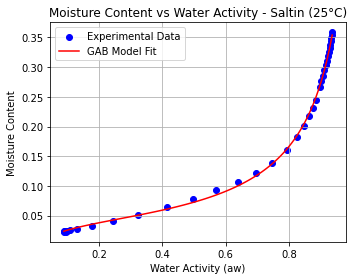

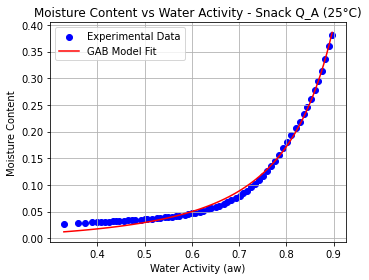

In [23]:
def fitted_plot(df, params, name):
    aw = df['aw']
    moisture = df['moisture']
    aw_fit = np.linspace(min(aw), max(aw), 100)
    W_m, C, K = params
    moisture_fit = gab_model(aw_fit, W_m, C, K)

    plt.figure(figsize=(5,4))
    plt.scatter(aw, moisture, color='blue', label='Experimental Data')
    plt.plot(aw_fit, moisture_fit, color='red', label='GAB Model Fit')
    plt.xlabel('Water Activity (aw)')
    plt.ylabel('Moisture Content')
    plt.title(f'Moisture Content vs Water Activity - {name} (25°C)')
    plt.legend()
    plt.grid()
    plt.show()

fitted_plot(saltin_df, params_saltin, 'Saltin')
fitted_plot(snack_qa_df, params_snack_qa, 'Snack Q_A')

### 1.3 Calculating shelf life
#### 1.3.1 Using time stepping methods to solve the ODE

In [34]:
# Determine the critical water activity value (aw_c)
# This value is calculated as the maximum of the curve
# aw/moisture Vs aw

# Define a general Polynomial model function for fitting
def polynomial_model(x, *coeffs):
    y_value = 0
    for i, coeff in enumerate(coeffs):
        y_value += coeff * (x**i)
    return y_value


def best_fit_curve(x_data, y_data):
    '''
    Test curve fitting for multiple degrees (polynomial)
    '''
    max_degree_to_test = 5
    fitted_results = []

    print("Testing Polynomial Fits")
    for degree in range(2, max_degree_to_test + 1):
        num_coeffs = degree + 1

        # Provide initial guesses for the coefficients. The length of p0
        # tells curve_fit how many parameters to fit.
        initial_guesses = np.ones(num_coeffs)

        print(f"\nFitting polynomial of degree {degree}...")
        try:
            # Perform the curve fit
            popt, pcov = curve_fit(polynomial_model, x_data, y_data, p0=initial_guesses)

            # Calculate y_fit and R-squared for goodness of fit
            y_fit = polynomial_model(x_data, *popt)
            residuals = y_data - y_fit
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y_data - np.mean(y_data))**2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 1.0
            
            # Store results
            fitted_results.append({
                'degree': degree,
                'popt': popt, # optimised parameters
                'pcov': pcov, # covariance matrix
                'r_squared': r_squared
            })
            print(f"  Coefficients: {np.round(popt, 3)}")
            print(f"  R-squared: {r_squared:.4f}")

        except RuntimeError:
            print(f"  Could not fit polynomial of degree {degree}. This often happens if the model is too complex for the data or initial guesses are poor.")
        except Exception as e:
            print(f"  An unexpected error occurred for degree {degree}: {e}")

    print(fitted_results)

    # Determine and display the best fit (e.g., highest R-squared)
    if fitted_results:
        # Sort by R-squared in descending order (higher is better)
        # You might also consider other metrics like AIC or BIC for model selection
        best_fit = sorted(fitted_results, key=lambda item: item['r_squared'], reverse=True)[0]
        print("\n--- Best Fit (based on R-squared) ---")
        print(f"Degree: {best_fit['degree']}")
        print(f"Coefficients: {np.round(best_fit['popt'], 3)}")
        print(f"R-squared: {best_fit['r_squared']:.4f}")

        # Plotting the results
        plt.figure(figsize=(12, 7))
        plt.scatter(x_data, y_data, label='Noisy Data', color='skyblue', s=30, zorder=1)
        # Plot the fitted curves
        for result in fitted_results:
            #if result['degree'] == best_fit['degree'] or result['degree'] <= 2: # Plot best and some lower degrees for comparison
            y_plot = polynomial_model(x_data, *result['popt'])
            plt.plot(x_data, y_plot, label=f'Fit Degree {result["degree"]} (R²={result["r_squared"]:.3f})', linewidth=1.5, zorder = 3 if result['degree'] == best_fit['degree'] else 2)

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.title('Polynomial Curve Fitting: Testing Multiple Degrees')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.show()
    else:
        best_fit = None
        print("\nNo successful fits were made.")

    # Find the maximum
    # Check if best_fit exists
    if 'best_fit' in locals() and best_fit and best_fit['popt'] is not None:
        coeffs_best = best_fit['popt']
        degree_best = best_fit['degree']

        print(f"\nAnalyzing Best Fit (Degree {degree_best}) for Local Maximum")

        # A local maximum (where P'(x)=0) requires degree >= 2.
        # For degree 0 (constant) or 1 (linear), extrema are at the boundaries of a defined interval.
        if degree_best < 2:
            print(f"  The best fit is a polynomial of degree {degree_best}.")
            print("  A local maximum (where derivative is zero and changes sign) generally requires a degree of 2 or higher.")

            # Check boundary values for linear/constant cases as they might be the max over the interval
            y_at_boundaries = polynomial_model(np.array([x_data[0], x_data[-1]]), *coeffs_best)
            if degree_best == 1: # Linear
                if coeffs_best[1] > 0: # Positive slope
                    print(f"  Linear function with positive slope: maximum on the interval [{x_data[0]:.2f}, {x_data[-1]:.2f}] is at x = {x_data[-1]:.2f}, y = {y_at_boundaries[1]:.2f}.")
                elif coeffs_best[1] < 0: # Negative slope
                    print(f"  Linear function with negative slope: maximum on the interval [{x_data[0]:.2f}, {x_data[-1]:.2f}] is at x = {x_data[0]:.2f}, y = {y_at_boundaries[0]:.2f}.")
                else: # Zero slope (effectively constant)
                    print(f"  The function is constant (degree=0): y = {coeffs_best[0]:.2f}.")
            else: # Degree 0 (constant)
                print(f"  The function is constant: y = {coeffs_best[0]:.2f}.")

        else: # Degree 2 or higher, can have true local maxima
            # np.polyder and np.polyval expect coefficients in decreasing order of power: [cn, ..., c1, c0]
            # Our 'coeffs_best' is [c0, c1, ..., cn]
            p_coeffs_numpy_order = np.array(coeffs_best)[::-1]

            # First derivative coefficients: P'(x)
            # np.polyder returns coefficients in the same (decreasing power) order
            p_prime_coeffs = np.polyder(p_coeffs_numpy_order, 1)

            # Second derivative coefficients: P''(x)
            p_double_prime_coeffs = np.polyder(p_coeffs_numpy_order, 2)

            # Find roots of the first derivative (x-values of critical points)
            critical_points_x_candidates = np.roots(p_prime_coeffs)

            potential_maxima_info = []
            x_data_min, x_data_max = np.min(x_data), np.max(x_data)

            if critical_points_x_candidates.size > 0:
                print(f"  Critical point candidates (x where P'(x)=0): {np.round(critical_points_x_candidates, 3)}")
                for cp_x_val in critical_points_x_candidates:
                    if np.isreal(cp_x_val): # Consider only real roots
                        cp_x = np.real(cp_x_val)

                        # Evaluate second derivative at this critical point
                        # np.polyval expects coefficients in decreasing power order
                        val_second_derivative = np.polyval(p_double_prime_coeffs, cp_x)

                        # Check for local maximum condition (P''(x) < 0)
                        # Using a small epsilon to avoid issues with floating point numbers near zero
                        if val_second_derivative < -1e-7:
                            # Calculate the y-value of the potential maximum
                            # polynomial_model expects coeffs as [c0, c1, ...]
                            y_at_cp = polynomial_model(cp_x, *coeffs_best)

                            is_within_data_range = (cp_x >= x_data_min) and (cp_x <= x_data_max)

                            potential_maxima_info.append({
                                'x': cp_x,
                                'y': y_at_cp,
                                'd2y_dx2': val_second_derivative,
                                'in_range': is_within_data_range
                            })
                            status_msg = "in data range" if is_within_data_range else "out of data range"
                            print(f"    Found potential local maximum ({status_msg}): x={cp_x:.3f}, y={y_at_cp:.3f}, P''(x)={val_second_derivative:.3f}")

                if potential_maxima_info:
                    # Filter for maxima within the x_data range
                    in_range_maxima = [m for m in potential_maxima_info if m['in_range']]

                    if in_range_maxima:
                        # Select the one with the highest y-value among those in range
                        identified_local_max = max(in_range_maxima, key=lambda m: m['y'])
                        print(f"\n  --> Identified Local Maximum (highest within data range):")
                        print(f"      Location: x = {identified_local_max['x']:.4f}")
                        print(f"      Value:    y = {identified_local_max['y']:.4f}")

                        # Store it for plotting (optional, depends on your script structure)
                        best_fit['local_maximum'] = identified_local_max

                    else: # No local maxima were found within the defined x_data range
                        print("\n  No local maxima (P'(x)=0, P''(x)<0) found within the x_data range.")
                        out_of_range_maxima = [m for m in potential_maxima_info if not m['in_range']]
                        if out_of_range_maxima:
                            print("    (However, potential local maxima were identified outside the x_data range.)")
                else: # No critical points satisfied the P''(x) < 0 condition
                    print("\n  No points satisfied the conditions for a local maximum (P'(x)=0 and P''(x)<0).")
            else: # The first derivative polynomial has no roots (e.g., if P'(x) is a non-zero constant)
                print("\n  No critical points found (the derivative P'(x) has no roots). This is unexpected for degree >= 2 polynomials.")
    else:
        print("Best fit model (best_fit) not available or not determined. Cannot find local maximum.")

    return best_fit

Testing Polynomial Fits

Fitting polynomial of degree 2...
  Coefficients: [  2.62   16.92  -17.974]
  R-squared: 0.9853

Fitting polynomial of degree 3...
  Coefficients: [  2.606  17.074 -18.338   0.231]
  R-squared: 0.9853

Fitting polynomial of degree 4...
  Coefficients: [  1.221  37.533 -99.198 116.927 -55.688]
  R-squared: 0.9979

Fitting polynomial of degree 5...
  Coefficients: [   0.736   46.291 -148.714  234.359 -178.603   46.959]
  R-squared: 0.9983
[{'degree': 2, 'popt': array([  2.61996465,  16.91965415, -17.97433724]), 'pcov': array([[ 0.0075756 , -0.03477543,  0.02953817],
       [-0.03477543,  0.22220168, -0.20673136],
       [ 0.02953817, -0.20673136,  0.19777249]]), 'r_squared': 0.9852589054110588}, {'degree': 3, 'popt': array([  2.60635507,  17.07423641, -18.33782163,   0.23134388]), 'pcov': array([[ 0.02545432, -0.23626495,  0.50170654, -0.29993622],
       [-0.23626495,  2.5054677 , -5.56584855,  3.4068087 ],
       [ 0.50170654, -5.56584855, 12.79030172, -8.01077

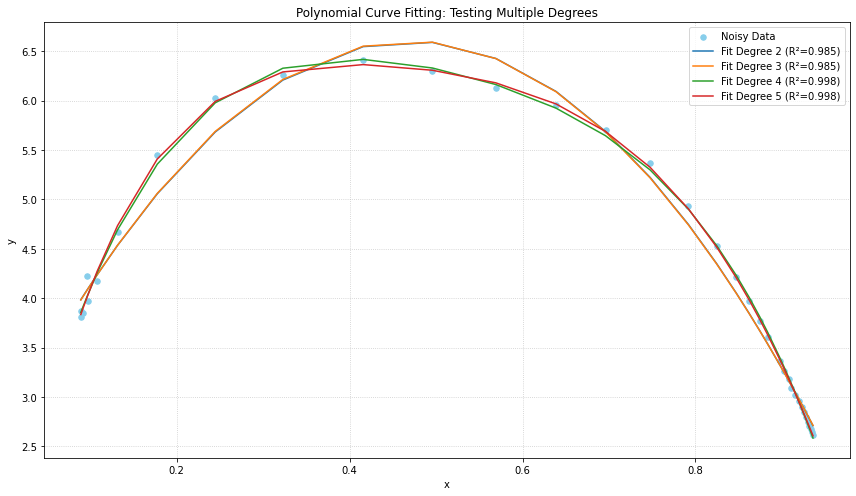


Analyzing Best Fit (Degree 5) for Local Maximum
  Critical point candidates (x where P'(x)=0): [1.648+0.j    0.494+0.224j 0.494-0.224j 0.406+0.j   ]
    Found potential local maximum (in data range): x=0.406, y=6.366, P''(x)=-16.988

  --> Identified Local Maximum (highest within data range):
      Location: x = 0.4058
      Value:    y = 6.3662
{'degree': 5, 'popt': array([   0.73617838,   46.29076432, -148.71374669,  234.35896107,
       -178.60317813,   46.95892868]), 'pcov': array([[ 4.58982712e-02, -7.72586652e-01,  4.04713990e+00,
        -9.01868922e+00,  8.98540274e+00, -3.29981081e+00],
       [-7.72586652e-01,  1.33107340e+01, -7.09768281e+01,
         1.60184099e+02, -1.61084430e+02,  5.95767634e+01],
       [ 4.04713990e+00, -7.09768281e+01,  3.86270388e+02,
        -8.85918245e+02,  9.01986874e+02, -3.36834139e+02],
       [-9.01868922e+00,  1.60184099e+02, -8.85918245e+02,
         2.05978826e+03, -2.12029137e+03,  7.98839746e+02],
       [ 8.98540274e+00, -1.61084430e+0

In [30]:
best_fit = best_fit_curve(saltin_df['aw'], saltin_df['aw']/saltin_df['moisture'])

In [33]:
# packaging parameters
P_w = 1e-12 # water vapour permeability of the package
A = 0.01 # surface area
L = 1e-3 # thickness
p_0 = 3170  # saturation vapour pressure of water (T = 30°C)
W_s = 0.05 # mass of dry solids of the food
aw_env = 0.6 # environmental water activity
if best_fit is not None:
    if 'local_maximum' in best_fit.keys():
        aw_c = best_fit['local_maximum']['x']
        print(f'Critical water activity found: {aw_c}')
    else:
        # Use a reference value
        aw_c = 0.5 # critical water activity of the food

Critical water activity found: 0.40577773195365413


In [35]:
def S_exp(aw, W_m, C, K):
    delta = 1e-5
    return (gab_model(aw+delta, W_m, C, K) - gab_model(aw-delta, W_m, C, K)) / (2 * delta)

def daw_dt_exp(t, aw, W_m, C, K):
    slope = S_exp(aw[0], W_m, C, K)
    if slope<= 0 or np.isnan(slope):
        return [0.0]
    return [(P_w * A * p_0 * (aw_env - aw[0])) / (W_s * L * slope)]

In [36]:
aw_0 = 0.05
t_span = (0, 1e7)
W_m, C, K = params_saltin  # Using Saltin parameters for the simulation
solver = solve_ivp(lambda t, aw: daw_dt_exp(t, aw, W_m, C, K), t_span, [aw_0], method='RK45', dense_output=True, max_step=100)

t_c = None
for t,aw in zip(solver.t, solver.y[0]):
    if aw >= aw_c:
        t_c = t/(60*60*24)
        break

if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 2.24987695 days


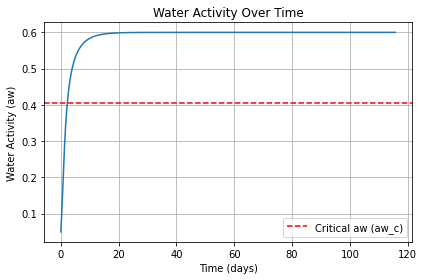

In [37]:
plt.plot(solver.t/(60*60*24), solver.y[0])
plt.xlabel('Time (days)')
plt.ylabel('Water Activity (aw)')
plt.title('Water Activity Over Time')
plt.axhline(y=aw_c, color='r', linestyle='--', label='Critical aw (aw_c)')
plt.legend()
plt.grid()
plt.show()

#### 1.3.2 Using numerical integration methods (Scipy: Adaptive Gauss-Legendre Quadrature)

In [125]:
def integrand(aw, W_m, C, K):
    slope = S_exp(aw, W_m, C, K)
    delta_aw = (aw_env - aw)
    if slope <= 0 or np.isnan(slope) or delta_aw <= 0:
        return 0.0
    return (W_s * L * slope) / (P_w * A * p_0 * delta_aw)

In [126]:
W_m, C, K = params_saltin  # Using Saltin parameters for the simulation
t, aw = quad(lambda aw: integrand(aw, W_m, C, K), aw_0, aw_c)

t_c = t / (60*60*24)
if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 3.91331077 days


#### 1.3.3 Using numerical integration methods (Manually: Trapezoidal Rule)

In [127]:
N = 1000
aw_vals = np.linspace(aw_0, aw_c, N + 1)
h = (aw_c - aw_0) / N

f_vals = np.array([integrand(aw, W_m, C, K) for aw in aw_vals]) # calculate the function values at each aw
t = h * (0.5 * f_vals[0] + np.sum(f_vals[1:-1]) + 0.5 * f_vals[-1]) # trapezoidal rule

t_c = t / (60*60*24)
if t_c is not None:
    print(f"Time to reach critical water activity (aw_c): {t_c:.8f} days")
else:
    print("Critical water activity not reached in given time span.")

Time to reach critical water activity (aw_c): 3.91331807 days


## 2. Lipid Oxidation

In [128]:
# parameters
E_a = 50000  # Activation energy in J/mol
Z = 1e6  # Pre-exponential factor in 1/s
R = 8.314  # Universal gas constant in J/(mol*K)
T_list = np.array([268, 273, 278, 283, 288, 293, 298, 303, 308, 313, 318])  # Temperatures in Kelvin

def k(T):
    return Z * np.exp(-E_a / (R * T))

k_ox = k(T_list)
t_ox = 1 / k_ox  # Oxidation time in seconds

print("Oxidation times at different temperatures (in seconds):")
for T, t in zip(T_list, t_ox):
    print(f"T = {T} K, t_ox = {t:.2f} s")


Oxidation times at different temperatures (in seconds):
T = 268 K, t_ox = 5566.99 s
T = 273 K, t_ox = 3690.88 s
T = 278 K, t_ox = 2483.47 s
T = 283 K, t_ox = 1694.60 s
T = 288 K, t_ox = 1171.77 s
T = 293 K, t_ox = 820.51 s
T = 298 K, t_ox = 581.46 s
T = 303 K, t_ox = 416.76 s
T = 308 K, t_ox = 301.96 s
T = 313 K, t_ox = 221.05 s
T = 318 K, t_ox = 163.41 s


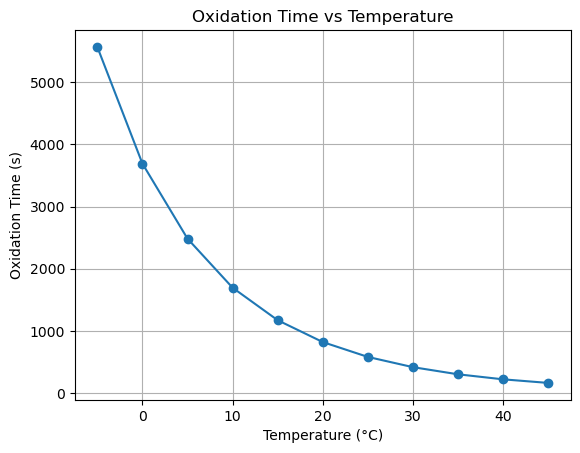

In [129]:
plt.plot(T_list - 273, t_ox, marker='o')
plt.xlabel('Temperature (°C)')
plt.ylabel('Oxidation Time (s)')
plt.title('Oxidation Time vs Temperature')
plt.grid()
plt.show()